In [1]:
import numpy as np
import time
import os
import shutil

import random
import pandas as pd

from pylab import *
import matplotlib.pyplot as plt
# from matplotlib_venn import *
%matplotlib inline
import seaborn as sns

from scipy import stats
from numpy.random import *

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

import statsmodels.stats.multitest 

/opt/anaconda3/envs/nb450/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# import data

In [2]:
datadir = "../data/"
outdir = "../result/"


In [3]:
df_anno = pd.read_csv(datadir+"epic_anno.csv.gz", index_col=0, skiprows=7)
df_samples = pd.read_csv(datadir+"4data_clin_age.csv",index_col=0)


/var/folders/50/qltdytt16kscm_hnx8gfl06c0000gr/T/ipykernel_9527/960035717.py:1: DtypeWarning: Columns (2,4,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df_anno = pd.read_csv(datadir+"epic_anno.csv.gz", index_col=0, skiprows=7)


# fig 2A

make "true_count_bysample.tsv" 

In [4]:
df = pd.read_csv(datadir+"true_count_bysample.tsv", header=None, sep="\t")
df.columns = ["ID", "selected", "True", "Prob", "MYCNA", "4s", "other", "4", "Class"]
df

,ID,selected,True,Prob,MYCNA,4s,other,4,Class
0,TARGET-30-PAIFXV-01A-01D,298,298,1.0,0,0,0,298,4
1,TARGET-30-PAIPGU-01A-01D,284,284,1.0,0,0,0,284,4
2,TARGET-30-PAISNS-01A-01D,299,299,1.0,0,0,0,299,4
3,TARGET-30-PAITCI-01A-01D,308,308,1.0,0,0,0,308,4
4,TARGET-30-PAIVHE-01A-01D,287,287,1.0,0,0,0,287,4
...,...,...,...,...,...,...,...,...,...
488,GSM3407024,311,311,1.0,0,0,311,0,other
489,GSM3407025,294,294,1.0,0,0,0,294,4
490,GSM3407026,304,304,1.0,0,0,304,0,other
491,GSM3407027,304,304,1.0,304,0,0,0,MYCNA


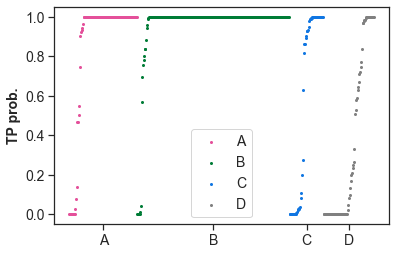

In [5]:
sns.set(font="Arial")
sns.set_style('ticks')

df_sort = df.sort_values("Prob", ascending=True).reset_index(drop=True)
df_sort
offset = 0
offset_ticks = []
labels = ["A","B","C","D"]
i=0
plt_cols = {"MYCNA":"#e4509a","4":"#007c36","4s":"#1076e2","other":"gray"}

for k in ["MYCNA","4","4s","other"]:
    df_tmp = df_sort.loc[df_sort["Class"]==k]
    plt.scatter(range(offset, offset+df_tmp.shape[0]), df_tmp["Prob"], s=4, label=labels[i], color=plt_cols[k])
    i += 1
    offset_ticks.append(offset+df_tmp.shape[0]/2)
    offset += df_tmp.shape[0]
    
# plt.xlabel("Lifetime", fontweight="bold", fontsize=18)
plt.ylabel("TP prob.", fontweight="bold", fontsize=14)
plt.xticks(offset_ticks,labels,fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
# plt.savefig(outdir+"KM_TP_ratio.pdf", bbox_inches='tight', pad_inches=0)

### fig 2B

In [6]:
df_misclass = df.loc[(df["Class"]=="other") & (df["Prob"]<0.5)]
print("df_misclass: class=other,plob<0.5",df_misclass.shape)
df_misclass = df.loc[(df["Class"]=="other") & (df["4"]>170)]
print("df_misclass: class=other,pred[4]>170",df_misclass.shape)
df_trueclass = df.loc[(df["Class"]=="other") & (df["other"]>150)]
print("df_trueclass: class=other,pred[other]>150",df_trueclass.shape)
df_4class=df.loc[(df["Class"]=="4") & (df["4"]>150)]
print("df_4class: class=4,pred[4]>150",df_4class.shape)

df_misclass: class=other,plob<0.5 (51, 9)
df_misclass: class=other,pred[4]>170 (35, 9)
df_trueclass: class=other,pred[other]>150 (31, 9)
df_4class: class=4,pred[4]>150 (239, 9)


In [7]:
df_misclass["ID"].to_csv(datadir+"class/df_misclass.txt", index=None)
df_trueclass["ID"].to_csv(datadir+"class/df_trueclass.txt", index=None)

In [8]:
df_D1 = pd.read_csv(datadir+"class/df_misclass.txt",header=None)
df_D2 = pd.read_csv(datadir+"class/df_trueclass.txt",header=None)


In [9]:
df_D1_tmp = pd.DataFrame()
for i,items in df_D1.iterrows():
    if items[0] not in df_samples.index:
        continue
    for k in df_samples.columns:
        df_D1_tmp.at[items[0], k] = df_samples.at[items[0], k]

df_D1_tmp.to_csv(datadir+"class/df_D1_anno.txt")

In [10]:
df_D2_tmp = pd.DataFrame()
for i,items in df_D2.iterrows():
    if items[0] not in df_samples.index:
        continue
    for k in df_samples.columns:
        df_D2_tmp.at[items[0], k] = df_samples.at[items[0], k]

df_D2_tmp.to_csv(datadir+"class/df_D2_anno.txt")

### fig 2C

(25, 10) (29, 10) (197, 10)


/var/folders/50/qltdytt16kscm_hnx8gfl06c0000gr/T/ipykernel_9527/743330674.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_A.loc[~data_A["Event_Free_Survival_Time_in_Days"].isnull(), "Event_Free_Survival_Time_in_Days"] = data_A["Event_Free_Survival_Time_in_Days"].astype(float)
/var/folders/50/qltdytt16kscm_hnx8gfl06c0000gr/T/ipykernel_9527/743330674.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_B.loc[~data_B["Event_Free_Survival_Time_in_Days"].isnull(), "Event_Free_Survival_Time_in_Days"] = data_B["Event_Free_Survival_Time_in_Days"].astype(float)
/var/folders/50/qltdytt16kscm_hnx8gfl06c0000gr/T/ipy

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           7.76 0.01      7.54

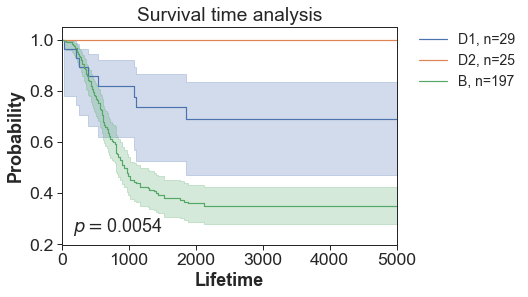

In [11]:
df_surv = pd.read_csv(datadir+'4data_clin.csv', index_col=0)

sns.set_style('ticks')
sns.set_context('paper', 2)

kmf = KaplanMeierFitter()

ax = None

data_A = df_surv.loc[(df_surv.index.isin(df_trueclass["ID"])) & (df_surv["Event_Free_Survival_Time_in_Days"] != "-") & (~df_surv["Event_Free_Survival_Time_in_Days"].isnull())]
data_B = df_surv.loc[(df_surv.index.isin(df_misclass["ID"])) & (df_surv["Event_Free_Survival_Time_in_Days"] != "-") & (~df_surv["Event_Free_Survival_Time_in_Days"].isnull())]
data_C = df_surv.loc[(df_surv.index.isin(df_4class["ID"])) & (df_surv["Event_Free_Survival_Time_in_Days"] != "-") & (~df_surv["Event_Free_Survival_Time_in_Days"].isnull())]
print (data_A.shape,data_B.shape,data_C.shape)

data_A.loc[~data_A["Event_Free_Survival_Time_in_Days"].isnull(), "Event_Free_Survival_Time_in_Days"] = data_A["Event_Free_Survival_Time_in_Days"].astype(float)
data_B.loc[~data_B["Event_Free_Survival_Time_in_Days"].isnull(), "Event_Free_Survival_Time_in_Days"] = data_B["Event_Free_Survival_Time_in_Days"].astype(float)
data_C.loc[~data_C["Event_Free_Survival_Time_in_Days"].isnull(), "Event_Free_Survival_Time_in_Days"] = data_C["Event_Free_Survival_Time_in_Days"].astype(float)

# data_A["Event_Free_Survival_Time_in_Days"] = data_A["Event_Free_Survival_Time_in_Days"].astype(float)
# data_B["Event_Free_Survival_Time_in_Days"] = data_B["Event_Free_Survival_Time_in_Days"].astype(float)
# data_C["Event_Free_Survival_Time_in_Days"] = data_C["Event_Free_Survival_Time_in_Days"].astype(float)

data_B.loc[data_B["alive/death"] == "D", "event"] = 1
data_B.loc[data_B["alive/death"] == "A", "event"] = 0
kmf.fit(data_B["Event_Free_Survival_Time_in_Days"], data_B["event"], label="D1, n="+str(len(data_B)))
# kmf.fit(data_B["Event_Free_Survival_Time_in_Days"], data_B["event"], label="D1")

ax = kmf.plot(ax=ax)

data_A.loc[data_A["alive/death"] == "D", "event"] = 1
data_A.loc[data_A["alive/death"] == "A", "event"] = 0
kmf.fit(data_A["Event_Free_Survival_Time_in_Days"], data_A["event"], label="D2, n="+str(len(data_A)))
# kmf.fit(data_A["Event_Free_Survival_Time_in_Days"], data_A["event"], label="D2")

ax = kmf.plot(title = "Survival time analysis")

data_C.loc[data_C["alive/death"] == "D", "event"] = 1
data_C.loc[data_C["alive/death"] == "A", "event"] = 0
kmf.fit(data_C["Event_Free_Survival_Time_in_Days"], data_C["event"], label="B, n="+str(len(data_C)))
# kmf.fit(data_C["Event_Free_Survival_Time_in_Days"], data_C["event"], label="B")

ax = kmf.plot(ax=ax)

results = logrank_test(data_A["Event_Free_Survival_Time_in_Days"], data_B["Event_Free_Survival_Time_in_Days"], data_A["event"], data_B["event"])
results.print_summary()
# plt.subplots_adjust(left=0.5, right=0, bottom=0.5, top=0)

plt.ylim([0.2,1.05])
plt.xlim([0,5000])
# plt.grid()
plt.xlabel("Lifetime", fontweight="bold", fontsize=18)
plt.ylabel("Probability", fontweight="bold", fontsize=18)
plt.text(170,0.25,r"$p = $"+str(round(results.p_value, 4)), fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,fontsize=14, frameon=0)

#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,fontsize=12)
# lgnd=plt.legend(bbox_to_anchor=(-0.15, -0.25), loc='upper left', borderaxespad=0,fontsize=14,ncol=2)
# lgnd.get_frame().set_linewidth(0.0)

plt.savefig(outdir+"KM_TP2.pdf", bbox_inches='tight', pad_inches=0)
#plt.show()

# fig 3D

In [37]:
df_beta = pd.read_csv(datadir+"4data_all.tsv.gz", index_col=0)
df_anno = pd.read_csv(datadir+"epic_anno.csv.gz", index_col=0)
# df_anno = pd.read_csv(datadir+"MethylationEPIC_v-1-0_B4.csv", index_col=0, skiprows=7)

/var/folders/50/qltdytt16kscm_hnx8gfl06c0000gr/T/ipykernel_9527/526368654.py:2: DtypeWarning: Columns (2,4,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df_anno = pd.read_csv(datadir+"epic_anno.csv.gz", index_col=0)


### calculate log-rank FDR

In [38]:
df_surv = pd.read_csv(datadir+'4data_clin.csv', index_col=0)
df_surv.loc[df_surv["alive/death"] == "D", "event"] = 1
df_surv.loc[df_surv["alive/death"] == "A", "event"] = 0

df_surv = df_surv.loc[df_surv["Event_Free_Survival_Time_in_Days"]!="-"]
df_surv["Event_Free_Survival_Time_in_Days"] = df_surv["Event_Free_Survival_Time_in_Days"].astype(float)
df_surv.loc[df_surv["event/not"].isnull(), "event"] = df_surv.loc[df_surv["event/not"].isnull(), "alive/death"] 



In [39]:
df_beta = df_beta[df_surv.index]

In [ ]:
# log-rank test
# This cell takes long time for calculation.

start = time.time()

df_res = pd.DataFrame()
# for k in ["cg04062576"]:
for k in df_beta.index:
# for k in df_beta.index[:1000]:
    kmf = KaplanMeierFitter()
    
    if df_res.shape[0] % 1000 == 0:
        print(df_res.shape[0], time.time() - start)
        

    data_A = df_surv.loc[df_beta.columns[df_beta.loc[k]>df_beta.loc[k].mean()]]
    data_B = df_surv.loc[df_beta.columns[df_beta.loc[k]<df_beta.loc[k].mean()]]

    results = logrank_test(data_A["Event_Free_Survival_Time_in_Days"], data_B["Event_Free_Survival_Time_in_Days"], data_A["event"], data_B["event"])
    df_res.at[k, "mean_beta"] = df_beta.loc[k].mean()
    df_res.at[k, "upper_mean_beta"] = data_A.shape[0]
    df_res.at[k, "lower_mean_beta"] = data_B.shape[0]
    df_res.at[k, "upper_mean_EFS"] = data_A["Event_Free_Survival_Time_in_Days"].mean()
    df_res.at[k, "lower_mean_EFS"] = data_B["Event_Free_Survival_Time_in_Days"].mean()
    df_res.at[k, "mean_p"] = results.p_value
    
    data_A = df_surv.loc[df_beta.columns[df_beta.loc[k]>df_beta.loc[k].median()]]
    data_B = df_surv.loc[df_beta.columns[df_beta.loc[k]<df_beta.loc[k].median()]]

    results = logrank_test(data_A["Event_Free_Survival_Time_in_Days"], data_B["Event_Free_Survival_Time_in_Days"], data_A["event"], data_B["event"])
    df_res.at[k, "median_beta"] = df_beta.loc[k].mean()
    df_res.at[k, "upper_median_beta"] = data_A.shape[0]
    df_res.at[k, "lower_median_beta"] = data_B.shape[0]
    df_res.at[k, "upper_median_EFS"] = data_A["Event_Free_Survival_Time_in_Days"].mean()
    df_res.at[k, "lower_median_EFS"] = data_B["Event_Free_Survival_Time_in_Days"].mean()
    df_res.at[k, "median_p"] = results.p_value

df_res

# plt.ylim([0.3,1.05])
# # plt.grid()
# plt.xlabel("Lifetime", fontweight="bold", fontsize=18)
# plt.ylabel("Probability", fontweight="bold", fontsize=18)
# plt.text(2500,0.35,"p = "+str(round(results.p_value, 4)), fontsize=18)

# # plt.savefig("/media/sugino/HDD2/project/machine_learning/NB_RF/NB_infi_20190423_MYCN_4_4s/fig/KM_TP.pdf", bbox_inches='tight', pad_inches=0)

In [ ]:
df_res["mean_FDR"] = statsmodels.stats.multitest.multipletests(df_res["mean_p"])[1]
df_res["median_FDR"] = statsmodels.stats.multitest.multipletests(df_res["median_p"])[1]
# statsmodels.stats.multitest.multipletests(df_res["mean_p"])[1]
df_res.to_csv("/media/sugino/HDD2/project/machine_learning/NB_RF/NB_infi_20191216_survival/beta_surv.csv")

### define diverce probes

In [40]:
# import surival time analysis result

df_res = pd.read_csv(datadir+"beta_surv.csv.gz",index_col=0)
df_res

,mean_beta,upper_mean_beta,lower_mean_beta,upper_mean_EFS,lower_mean_EFS,mean_p,median_beta,upper_median_beta,lower_median_beta,upper_median_EFS,lower_median_EFS,median_p,mean_FDR,median_FDR
cg07881041,0.729968,271.0,222.0,1651.462555,1435.390374,0.047255,0.729968,246.0,246.0,1660.087379,1453.135266,0.214744,1.0,1.0
cg18478105,0.031630,227.0,266.0,1679.975610,1471.136000,0.607563,0.031630,246.0,246.0,1708.285714,1437.922078,0.500385,1.0,1.0
cg23229610,0.832619,311.0,182.0,1506.901887,1637.389262,0.446055,0.832619,246.0,246.0,1499.108491,1611.331683,0.752051,1.0,1.0
cg03513874,0.529762,257.0,236.0,1664.397196,1435.595000,0.268597,0.529762,246.0,246.0,1679.514563,1421.879227,0.288905,1.0,1.0
cg09835024,0.041196,214.0,279.0,1558.305699,1549.986425,0.103746,0.041196,246.0,246.0,1569.908676,1535.846154,0.022715,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg18416871,0.390824,213.0,280.0,1533.748603,1569.187234,0.243976,0.390824,246.0,246.0,1520.730392,1589.009569,0.181444,1.0,1.0
cg07280272,0.704189,310.0,183.0,1667.559387,1359.915033,0.003366,0.704189,246.0,246.0,1666.685714,1430.871921,0.016043,1.0,1.0
cg23822052,0.065598,213.0,280.0,1505.375635,1597.884793,0.063906,0.065598,246.0,246.0,1496.119469,1629.657754,0.048644,1.0,1.0
cg12074221,0.391181,213.0,280.0,1541.107527,1564.271930,0.581355,0.391181,246.0,246.0,1501.168224,1616.381910,0.936973,1.0,1.0


In [41]:
data_A = df_surv.loc[(df_surv.index.isin(df_trueclass["ID"])) & (df_surv["Event_Free_Survival_Time_in_Days"]!="-") & (~df_surv["Event_Free_Survival_Time_in_Days"].isnull())]
data_B = df_surv.loc[(df_surv.index.isin(df_misclass["ID"])) & (df_surv["Event_Free_Survival_Time_in_Days"]!="-") & (~df_surv["Event_Free_Survival_Time_in_Days"].isnull())]

print(data_A.shape, data_B.shape)

(25, 11) (29, 11)


In [42]:
MYCNA = df_surv.loc[df_surv["MYCN"]=="Y"].index
INSS4 = df_surv.loc[(df_surv["MYCN"]=="N") & (df_surv["stage"]=="4")].index
INSS4s = df_surv.loc[(df_surv["MYCN"]=="N") & (df_surv["stage"]=="4s")].index
other = df_surv.loc[(df_surv["MYCN"]=="N") & ~(df_surv["stage"]=="4") & ~(df_surv["stage"]=="4s")].index


In [43]:
df_age = pd.read_csv(datadir+"4data_clin_age.csv", index_col = 0)
df_age

,class,dataset,stage,MYCN,event/not,relapse/otherevent/not,alive/death,Event_Free_Survival_Time_in_Days,Overall_Survival_Time_in_Days,FirstEvent,diag_class,diag_age
ID,,,,,,,,,,,,
TARGET-30-PAIFXV-01A-01D,4Noamp,Target,4,N,Event,Event,D,630.0,1114.0,death of disease,1,2004
TARGET-30-PAIPGU-01A-01D,4Noamp,Target,4,N,Event,Death,D,436.0,436.0,death of disease,1,898
TARGET-30-PAISNS-01A-01D,4Noamp,Target,4,N,Event,Event,D,410.0,421.0,death of disease,1,1070
TARGET-30-PAITCI-01A-01D,4Noamp,Target,4,N,Event,Event,D,232.0,324.0,death of disease,1,728
TARGET-30-PAIVHE-01A-01D,4Noamp,Target,4,N,Event,Event,D,672.0,1605.0,death of disease,1,1123
...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3407024,other,Ackermann,1,N,Event,relapse/progression,D,NaN,NaN,relapse/progression,0,0
GSM3407025,4Noamp,Ackermann,4,N,Not,no event,A,268.0,268.0,no event,1,2786
GSM3407026,other,Ackermann,3,N,Not,no event,A,NaN,NaN,no event,0,323


In [44]:
df_trueclass.index = df_trueclass["ID"]

In [45]:
for i, items in df_trueclass.iterrows():
    print(items["ID"], df_age.loc[items["ID"]]["diag_age"], items["ID"])
    # df_trueclass.at[i, "diag_age1"] = df_age.loc[items["ID"]]["diag_age"]
    df_trueclass.at[i, "diag_age1"] = df_age.at[items["ID"], "diag_age"]
    age = ""
    if df_age.at[items["ID"], "diag_age"]=="<1.5 years":
        age = "<1.5 years"
    elif df_age.at[items["ID"], "diag_age"]==">=1.5 years":
        age = ">=1.5 years"
    elif int(df_age.at[items["ID"], "diag_age"])<520:
        age = "<1.5 years"
    elif int(df_age.at[items["ID"], "diag_age"])>=520:
        age = ">=1.5 years"
    df_trueclass.at[i, "diag_age"] = age
    df_trueclass.at[i, "event/not"] = df_age.at[items["ID"], "event/not"]
    df_trueclass.at[i, "relapse/otherevent/not"] = df_age.at[items["ID"], "relapse/otherevent/not"]
    df_trueclass.at[i, "alive/death"] = df_age.at[items["ID"], "alive/death"]
    
#     event/not 	relapse/otherevent/not 	alive/death
df_trueclass

TARGET-30-PAKGCI-01A-01D 300 TARGET-30-PAKGCI-01A-01D
TARGET-30-PALKKV-01A-01D 283 TARGET-30-PALKKV-01A-01D
TARGET-30-PALLJJ-01A-01D 388 TARGET-30-PALLJJ-01A-01D
TARGET-30-PALRIA-01A-01D 685 TARGET-30-PALRIA-01A-01D
TARGET-30-PAMAFV-01A-01D 303 TARGET-30-PAMAFV-01A-01D
TARGET-30-PARZCJ-01A-01D 242 TARGET-30-PARZCJ-01A-01D
TARGET-30-PASNPG-01A-01D 318 TARGET-30-PASNPG-01A-01D
TARGET-30-PAUDDK-01A-01D 361 TARGET-30-PAUDDK-01A-01D
GSM1896916 <1.5 years GSM1896916
GSM1896918 <1.5 years GSM1896918
GSM1896929 <1.5 years GSM1896929
GSM1896942 <1.5 years GSM1896942
GSM1896948 <1.5 years GSM1896948
GSM1896951 <1.5 years GSM1896951
GSM1896954 <1.5 years GSM1896954
GSM1896956 <1.5 years GSM1896956
GSM1896959 <1.5 years GSM1896959
GSM1896968 <1.5 years GSM1896968
GSM1896978 <1.5 years GSM1896978
GSM1896985 <1.5 years GSM1896985
GSM1896993 <1.5 years GSM1896993
GSM1896995 <1.5 years GSM1896995
B_NB52_TG1 0 B_NB52_TG1
B_NB19_TG1 240 B_NB19_TG1
GSM3406974 22 GSM3406974
GSM3406978 229 GSM3406978
GSM34

,ID,selected,True,Prob,MYCNA,4s,other,4,Class,diag_age1,diag_age,event/not,relapse/otherevent/not,alive/death
ID,,,,,,,,,,,,,,
TARGET-30-PAKGCI-01A-01D,TARGET-30-PAKGCI-01A-01D,271,171,0.630996,0,100,171,0,other,300,<1.5 years,Not,Censored,A
TARGET-30-PALKKV-01A-01D,TARGET-30-PALKKV-01A-01D,309,238,0.770227,0,62,238,9,other,283,<1.5 years,Not,Censored,A
TARGET-30-PALLJJ-01A-01D,TARGET-30-PALLJJ-01A-01D,297,287,0.966330,0,2,287,8,other,388,<1.5 years,Not,Censored,A
TARGET-30-PALRIA-01A-01D,TARGET-30-PALRIA-01A-01D,332,239,0.719880,0,0,239,93,other,685,>=1.5 years,Not,Censored,A
TARGET-30-PAMAFV-01A-01D,TARGET-30-PAMAFV-01A-01D,334,323,0.967066,0,8,323,3,other,303,<1.5 years,Not,Censored,A
TARGET-30-PARZCJ-01A-01D,TARGET-30-PARZCJ-01A-01D,309,179,0.579288,0,94,179,36,other,242,<1.5 years,Not,Censored,A
TARGET-30-PASNPG-01A-01D,TARGET-30-PASNPG-01A-01D,320,169,0.528125,0,0,169,151,other,318,<1.5 years,Event,Event,A
TARGET-30-PAUDDK-01A-01D,TARGET-30-PAUDDK-01A-01D,305,298,0.977049,0,0,298,7,other,361,<1.5 years,Event,Event,A
GSM1896916,GSM1896916,292,292,1.000000,0,0,292,0,other,<1.5 years,<1.5 years,Not,alive without event,A


In [46]:
B1 = df_age.loc[(df_age["stage"]=="4") & (df_surv["MYCN"]=="N") & (df_age["diag_age"]=="<1.5 years")].index
A = df_surv.loc[(df_surv["MYCN"]=="Y")].index
B2 = df_surv.loc[(df_surv["MYCN"]=="N") & (df_surv["stage"]=="4") & (~df_surv.index.isin(B1))].index
C = df_surv.loc[(df_surv["MYCN"]=="N") & (df_surv["stage"]=="4s")].index
# other = df_surv.loc[(df_surv["MYCN"]=="N") & ~(df_surv["stage"]=="4") & ~(df_surv["stage"]=="4s")].index

D1 = df.loc[(df["Class"]=="other") & (df["4"]>170)]["ID"]
D2 = df.loc[(df["Class"]=="other") & (df["other"]>150)]["ID"]

D1 = D1[D1.isin(df_beta.columns)]
D2 = D2[D2.isin(df_beta.columns)]


In [47]:
HRyoung = df_age.loc[(df_age["stage"]=="4") & (df_age["diag_age"]=="<1.5 years")].index
HRyoungA = df_age.loc[(df_age["stage"]=="4") & (df_age["MYCN"]=="Y") & (df_age["diag_age"]=="<1.5 years")].index
HRyoungN = df_age.loc[(df_age["stage"]=="4") & (df_age["MYCN"]=="N") & (df_age["diag_age"]=="<1.5 years")].index

# pd.DataFrame(HRyoung).to_csv(wd+"data/class/HRyoung.txt", index=None, header=None)
pd.DataFrame(B1).to_csv(datadir+"class/B1.txt", index=None, header=None)
pd.DataFrame(B2).to_csv(datadir+"class/B2.txt", index=None, header=None)

pd.DataFrame(HRyoungA).to_csv(datadir+"class/HRyoungA.txt", index=None, header=None)
pd.DataFrame(HRyoungN).to_csv(datadir+"class/HRyoungN.txt", index=None, header=None)


In [48]:
a = df_beta[abs(df_beta[D1].mean(axis=1)-df_beta[D2].mean(axis=1))>0.3]
a = a.loc[a.mean(axis=1).sort_values(ascending=True).keys()]
sorted_sample = list(a[B1].mean().sort_values(ascending=False).keys())
sorted_sample.extend(list(a[A].mean().sort_values(ascending=False).keys()))
sorted_sample.extend(list(a[B2].mean().sort_values(ascending=False).keys()))
sorted_sample.extend(list(a[C].mean().sort_values(ascending=False).keys()))
sorted_sample.extend(list(a[D1].mean().sort_values(ascending=False).keys()))
sorted_sample.extend(list(a[D2].mean().sort_values(ascending=False).keys()))


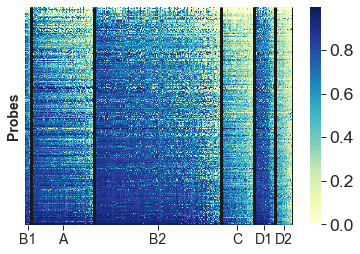

In [49]:
fig, ax = plt.subplots()

sns.heatmap(a[sorted_sample],xticklabels=True, cmap="YlGnBu")
# plt.xticks("''")
ax.tick_params(labelbottom=True,labelleft=False,labelright=False,labeltop=False)
labels = [len(B1)/2,len(B1)+len(A)/2,len(B1)+len(A)+len(B2)/2,len(B1)+len(A)+len(B2)+len(C)/2,len(B1)+len(A)+len(B2)+len(C)+len(D1)/2,len(B1)+len(A)+len(B2)+len(C)+len(D1)+len(D2)/2]
ax.set_xticks(labels)
# ax.set_xticklabels(["HRyoung","MYCNA","INSS4","INSS4s","LSA","LST"], rotation=-45, ha="left")
ax.set_xticklabels(["B1","A","B2","C","D1","D2"], rotation=0, size=14)

ax.set_yticks([])
ax.set_ylabel("Probes", size=14, weight="bold")

lw=3
ax.vlines(len(B1),0,a.shape[0],"k",linewidth=lw)
ax.vlines(len(B1)+len(A),0,a.shape[0],"k",linewidth=lw)
ax.vlines(len(B1)+len(A)+len(B2),0,a.shape[0],"k",linewidth=lw)
ax.vlines(len(B1)+len(A)+len(B2)+len(C),0,a.shape[0],"k",linewidth=lw)
ax.vlines(len(B1)+len(A)+len(B2)+len(C)+len(D1),0,a.shape[0],"k",linewidth=lw)
ax.vlines(len(B1)+len(A)+len(B2)+len(C)+len(D1)+len(D2),0,a.shape[0],"k",linewidth=lw)
# plt.savefig(outdir+"heatmap_sorted.pdf", bbox_inches='tight')

plt.show()

# Fig S3

In [50]:
df_logrank = pd.read_csv(datadir+"beta_surv.csv.gz", index_col=0)
df_logrank.columns[:14]
df_logrank.head()


,mean_beta,upper_mean_beta,lower_mean_beta,upper_mean_EFS,lower_mean_EFS,mean_p,median_beta,upper_median_beta,lower_median_beta,upper_median_EFS,lower_median_EFS,median_p,mean_FDR,median_FDR
cg07881041,0.729968,271.0,222.0,1651.462555,1435.390374,0.047255,0.729968,246.0,246.0,1660.087379,1453.135266,0.214744,1.0,1.0
cg18478105,0.031630,227.0,266.0,1679.975610,1471.136000,0.607563,0.031630,246.0,246.0,1708.285714,1437.922078,0.500385,1.0,1.0
cg23229610,0.832619,311.0,182.0,1506.901887,1637.389262,0.446055,0.832619,246.0,246.0,1499.108491,1611.331683,0.752051,1.0,1.0
cg03513874,0.529762,257.0,236.0,1664.397196,1435.595000,0.268597,0.529762,246.0,246.0,1679.514563,1421.879227,0.288905,1.0,1.0
cg09835024,0.041196,214.0,279.0,1558.305699,1549.986425,0.103746,0.041196,246.0,246.0,1569.908676,1535.846154,0.022715,1.0,1.0


In [51]:
a = df_beta
a = a.loc[a.mean(axis=1).sort_values(ascending=True).keys()]
sorted_sample = list(a[B1].mean().sort_values(ascending=False).keys())
sorted_sample.extend(list(a[A].mean().sort_values(ascending=False).keys()))
sorted_sample.extend(list(a[B2].mean().sort_values(ascending=False).keys()))
sorted_sample.extend(list(a[C].mean().sort_values(ascending=False).keys()))
sorted_sample.extend(list(a[D1].mean().sort_values(ascending=False).keys()))
sorted_sample.extend(list(a[D2].mean().sort_values(ascending=False).keys()))

b=pd.DataFrame()
b["B1"] = a[B1].mean(axis=1)
b["C"] = a[C].mean(axis=1)
b["D1"] = a[D1].mean(axis=1)
b["D2"] = a[D2].mean(axis=1)
b["B1-C"] = b["B1"]-b["C"]
b["B1-D2"] = b["B1"]-b["D2"]
b = b.sort_values("B1-C")
b = b.sort_values("B1-D2")
b

,B1,C,D1,D2,B1-C,B1-D2
ID_REF,,,,,,
cg01253711,0.133971,0.379724,0.442153,0.557801,-0.245753,-0.423829
cg19595402,0.129903,0.384444,0.211252,0.545303,-0.254541,-0.415401
cg14521995,0.091857,0.668493,0.710948,0.505056,-0.576636,-0.413199
cg09462281,0.431159,0.793899,0.588454,0.780422,-0.362741,-0.349264
cg19082708,0.141569,0.325026,0.474968,0.481125,-0.183457,-0.339556
...,...,...,...,...,...,...
cg14018024,0.746342,0.499157,0.787460,0.293775,0.247186,0.452567
cg02939767,0.741669,0.429013,0.774879,0.287099,0.312656,0.454570
cg26232417,0.673892,0.318387,0.705119,0.190297,0.355505,0.483596


In [54]:
b = b.join(df_anno[["UCSC_RefGene_Name","UCSC_RefGene_Accession","UCSC_RefGene_Group","Relation_to_UCSC_CpG_Island","450k_Enhancer"]])

In [55]:
df_logrank
# b

,mean_beta,upper_mean_beta,lower_mean_beta,upper_mean_EFS,lower_mean_EFS,mean_p,median_beta,upper_median_beta,lower_median_beta,upper_median_EFS,lower_median_EFS,median_p,mean_FDR,median_FDR
cg07881041,0.729968,271.0,222.0,1651.462555,1435.390374,0.047255,0.729968,246.0,246.0,1660.087379,1453.135266,0.214744,1.0,1.0
cg18478105,0.031630,227.0,266.0,1679.975610,1471.136000,0.607563,0.031630,246.0,246.0,1708.285714,1437.922078,0.500385,1.0,1.0
cg23229610,0.832619,311.0,182.0,1506.901887,1637.389262,0.446055,0.832619,246.0,246.0,1499.108491,1611.331683,0.752051,1.0,1.0
cg03513874,0.529762,257.0,236.0,1664.397196,1435.595000,0.268597,0.529762,246.0,246.0,1679.514563,1421.879227,0.288905,1.0,1.0
cg09835024,0.041196,214.0,279.0,1558.305699,1549.986425,0.103746,0.041196,246.0,246.0,1569.908676,1535.846154,0.022715,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg18416871,0.390824,213.0,280.0,1533.748603,1569.187234,0.243976,0.390824,246.0,246.0,1520.730392,1589.009569,0.181444,1.0,1.0
cg07280272,0.704189,310.0,183.0,1667.559387,1359.915033,0.003366,0.704189,246.0,246.0,1666.685714,1430.871921,0.016043,1.0,1.0
cg23822052,0.065598,213.0,280.0,1505.375635,1597.884793,0.063906,0.065598,246.0,246.0,1496.119469,1629.657754,0.048644,1.0,1.0
cg12074221,0.391181,213.0,280.0,1541.107527,1564.271930,0.581355,0.391181,246.0,246.0,1501.168224,1616.381910,0.936973,1.0,1.0


In [56]:
b = b.join(df_logrank[["mean_FDR","median_FDR","upper_mean_EFS","lower_mean_EFS","upper_median_beta","lower_median_beta"]])

In [57]:
b = b.loc[(b["mean_FDR"]!=1)]


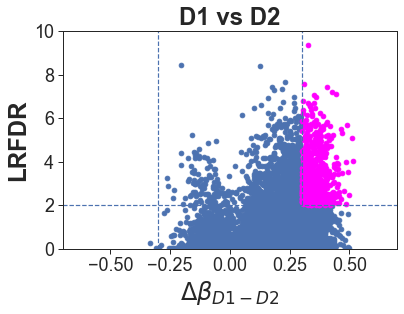

In [58]:
sns.set_style('ticks')

fig, ax = plt.subplots()

tmp2 = b.loc[(b["mean_FDR"]>0.01) | (abs(b["D1"]-b["D2"])<0.3)]
plt.scatter(tmp2["D1"]-tmp2["D2"], -log10(tmp2["mean_FDR"]))
tmp1 = b.loc[(b["mean_FDR"]<0.01) & (abs(b["D1"]-b["D2"])>0.3)]
plt.scatter(tmp1["D1"]-tmp1["D2"], -log10(tmp1["mean_FDR"]), color="magenta")


# plt.scatter(b["D1"]-b["D2"], -log10(b["mean_FDR"]))
ax.hlines(y=2, xmin=-1, xmax=1, linestyles='dashed')
ax.vlines(x=0.3, ymin=0, ymax=10, linestyles='dashed')
ax.vlines(x=-0.3, ymin=0, ymax=10, linestyles='dashed')
# plt.hline(2,(-1,1))
plt.xlim([-.7,.7])
plt.ylim([0,10])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"$\Delta\beta_{D1-D2}$", size=24, weight="bold")
plt.ylabel("LRFDR", size=24, weight="bold")
plt.title("D1 vs D2", size=24, weight="bold")
plt.savefig(outdir+"D1D2.png", bbox_inches='tight')
plt.show()

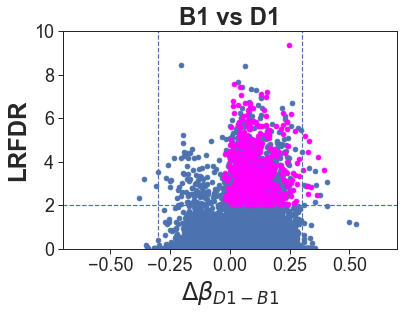

In [59]:
fig, ax = plt.subplots()

# tmp = b.loc[(b["mean_FDR"]<0.01) & (abs(b["B1"]-b["D1"])>0.3)]
tmp2 = b.loc[(b["mean_FDR"]>0.01) | (abs(b["D1"]-b["D2"])<0.3)]
plt.scatter(tmp2["D1"]-tmp2["B1"], -log10(tmp2["mean_FDR"]))
tmp1 = b.loc[(b["mean_FDR"]<0.01) & (abs(b["D1"]-b["D2"])>0.3)]
plt.scatter(tmp1["D1"]-tmp1["B1"], -log10(tmp1["mean_FDR"]), color="magenta")

# plt.scatter(b["B1"]-b["D1"], -log10(b["mean_FDR"]))
ax.hlines(y=2, xmin=-1, xmax=1, linestyles='dashed')
ax.vlines(x=0.3, ymin=0, ymax=10, linestyles='dashed')
ax.vlines(x=-0.3, ymin=0, ymax=10, linestyles='dashed')
# plt.hline(2,(-1,1))
plt.xlim([-.7,.7])
plt.ylim([0,10])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"$\Delta \beta_{D1-B1}$", size=24, weight="bold")
plt.ylabel("LRFDR", size=24, weight="bold")
plt.title("B1 vs D1", size=24, weight="bold")
plt.savefig(outdir+"B1D1.png", bbox_inches='tight')
plt.show()

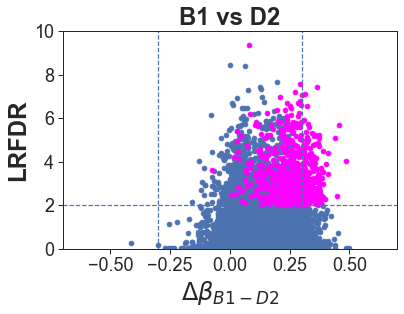

In [60]:
fig, ax = plt.subplots()

tmp2 = b.loc[(b["mean_FDR"]>0.01) | (abs(b["D1"]-b["D2"])<0.3)]
plt.scatter(tmp2["B1"]-tmp2["D2"], -log10(tmp2["mean_FDR"]))
tmp1 = b.loc[(b["mean_FDR"]<0.01) & (abs(b["D1"]-b["D2"])>0.3)]
plt.scatter(tmp1["B1"]-tmp1["D2"], -log10(tmp1["mean_FDR"]), color="magenta")

ax.hlines(y=2, xmin=-1, xmax=1, linestyles='dashed')
ax.vlines(x=0.3, ymin=0, ymax=10, linestyles='dashed')
ax.vlines(x=-0.3, ymin=0, ymax=10, linestyles='dashed')
# plt.hline(2,(-1,1))
plt.xlim([-.7,.7])
plt.ylim([0,10])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"$\Delta\beta_{B1-D2}$", size=24, weight="bold")
plt.ylabel("LRFDR", size=24, weight="bold")
plt.title("B1 vs D2", size=24, weight="bold")
plt.savefig(outdir+"B1D2.png", bbox_inches='tight')
plt.show()